This file is to do the main regression with graph metrics from FC. 

Currently, the regression has two steps, 

1. Regression with all features and ridge penalty, and select the siginifcant features.
    - The brain plots are based on this results

2. Regression with the selected features and ridge penalty again. 
    - The AUC is reported with this regression
    
I also include some TA SA feature

I also plot the AUC for all 4 methods in this file


In [1]:
import sys
sys.path.append("../../")
from pathlib import Path
root = Path("../../")

PosixPath('../..')

In [2]:
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
import statsmodels.api as sm
from joblib import Parallel, delayed
%matplotlib inline

In [3]:
import importlib
import pyTVDN.utils
importlib.reload(pyTVDN.utils)
from pyTVDN.utils import load_pkl, save_pkl

In [4]:
with open(root/"OtherFils/data_roi_order.txt", "r") as f:
    region_names_raw = f.readlines()
region_names_raw
region_names = [i.strip()[4].title() + i.strip()[6:].title() 
               for i in region_names_raw if len(i.strip())>0];

In [5]:
resDir = root/"results"
dataDir = root/"data"

PosixPath('../../data')

## Load features

### Load data

In [6]:
kpAD, kpCtrl, kpAll = load_pkl(root/"OtherFils/KpIdxsAll.pkl")

In [7]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
ecptssAD = load_pkl(fil)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
ecptssCtrl = load_pkl(fil);

In [8]:
# Eigvals
fil = list(resDir.glob("AD_*_eigVals.pkl"))[0]
eigValsAD = load_pkl(fil)
fil = list(resDir.glob("Ctrl_*_eigVals.pkl"))[0]
eigValsCtrl = load_pkl(fil);

In [9]:
fil = list(resDir.glob("AD_*_eigVecs.pkl"))[0]
eigVecsAD = load_pkl(fil)
fil = list(resDir.glob("Ctrl_*_eigVecs.pkl"))[0]
eigVecsCtrl = load_pkl(fil);

In [10]:
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]
eigVecsAD = [ v for v, kpix in zip(eigVecsAD, kpAD) if kpix==1]
eigVecsCtrl = [ v for v, kpix in zip(eigVecsCtrl, kpCtrl) if kpix==1];

In [11]:
TAs_AD = load_pkl(resDir/"neuroimage_r1/SA_TA_features/TA_AD_nofilter.pkl");
TAs_Ctrl = load_pkl(resDir/"neuroimage_r1/SA_TA_features/TA_Ctrl_nofilter.pkl");
SAs_AD = load_pkl(resDir/"neuroimage_r1/SA_TA_features/SA_AD_nofilter.pkl");
SAs_Ctrl = load_pkl(resDir/"neuroimage_r1/SA_TA_features/SA_Ctrl_nofilter.pkl");

TAs_AD = TAs_AD[kpAD==1]
TAs_Ctrl = TAs_Ctrl[kpCtrl==1]
SAs_AD = SAs_AD[kpAD==1]
SAs_Ctrl = SAs_Ctrl[kpCtrl==1];

In [12]:
# graph metrics from TVDN
graph_fs_AD = load_pkl(resDir/"graphic_fs_AD.pkl")
graph_fs_Ctrl = load_pkl(resDir/"graphic_fs_Ctrl.pkl");

In [13]:
### The canonical networks
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

def minmax_brainplotting(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den + 1e-3

fcR = pd.read_csv(resDir/'../OtherFils/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    # minmax does not affect pearson corr
    fcRarrMM[i, :] = minmax(fcRar)

In [14]:
# calculat the topk mean of graphic feature based on dwell time
def topk_mean(topk, graphic_f, dwell, key):
    idxs = np.argsort(-dwell)[:topk]
    sel_graphic_f = np.array([graphic_f[idx][key] for idx in idxs])
    mean_v = np.mean(sel_graphic_f)
    return mean_v

### The basic data transformation 

In [15]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl];

In [16]:
ecptss = ecptssAD
dwells = dwellsAD
eigVals = eigValsAD
eigVecs = eigVecsAD
TAs = TAs_AD
SAs = SAs_AD
graph_fs = graph_fs_AD

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    
    idx = np.argmax(dwell)
    maxEigVal = eigVal[idx]
    fs.r  = len(maxEigVal)
    
    # graph metric
    graph_f = graph_fs[i]
    fs["top1_Q"] = topk_mean(1, graph_f, dwell, "tQ")
    fs["top1_C"] = topk_mean(1, graph_f, dwell, "tmC")
    fs["top1_L"] = topk_mean(1, graph_f, dwell, "tmL")
    fs["mean_Q"] = np.mean([v["tQ"] for v in graph_f])
    fs["mean_C"] = np.mean([v["tmC"] for v in graph_f])
    fs["mean_L"] = np.mean([v["tmL"] for v in graph_f])
    fs["var_Q"] = np.var([v["tQ"] for v in graph_f])
    fs["var_C"] = np.var([v["tmC"] for v in graph_f])
    fs["var_L"] = np.var([v["tmL"] for v in graph_f])
    
    # TA SA
    fs.gTA = TAs[i].mean()
    fs.SA_inf = SAs[i, 0]
    fs.SA_lam = SAs[i, 1]
    
    fsAll.append(fs)
    
fsAD = fsAll;    

In [17]:
ecptss = ecptssCtrl
dwells = dwellsCtrl
eigVals = eigValsCtrl
eigVecs = eigVecsCtrl
TAs = TAs_Ctrl
SAs = SAs_Ctrl
graph_fs = graph_fs_Ctrl

fsAll = []
for i in range(len(ecptss)):
    fs = edict()
    dwell = dwells[i]
    fs.dwell = dwell 
    fs.ncpts = len(ecptss[i])
    fs.meanDwell = np.mean(dwell)
    fs.maxDwell = np.max(dwell)
    fs.minDwell = np.min(dwell)
    
    eigVal = eigVals[i]
    fs.wUmeanAll = np.abs(np.matmul(eigVecs[i], np.array(eigVal).T).real).mean(axis=1)
    
    idx = np.argmax(dwell)
    maxEigVal = eigVal[idx]
    fs.r  = len(maxEigVal)
    
    # graph metric
    graph_f = graph_fs[i]
    fs["top1_Q"] = topk_mean(1, graph_f, dwell, "tQ")
    fs["top1_C"] = topk_mean(1, graph_f, dwell, "tmC")
    fs["top1_L"] = topk_mean(1, graph_f, dwell, "tmL")
    fs["mean_Q"] = np.mean([v["tQ"] for v in graph_f])
    fs["mean_C"] = np.mean([v["tmC"] for v in graph_f])
    fs["mean_L"] = np.mean([v["tmL"] for v in graph_f])
    fs["var_Q"] = np.var([v["tQ"] for v in graph_f])
    fs["var_C"] = np.var([v["tmC"] for v in graph_f])
    fs["var_L"] = np.var([v["tmL"] for v in graph_f])
    
    # TA SA
    fs.gTA = TAs[i].mean()
    fs.SA_inf = SAs[i, 0]
    fs.SA_lam = SAs[i, 1]
    
    fsAll.append(fs)
    
fsCtrl = fsAll;    

##  Regression in TVDN

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict

import matplotlib.cbook as cbook
import statsmodels.api as sm

from sklearn.cluster import KMeans, SpectralClustering
from scipy.stats import fisher_exact, norm
from prettytable import PrettyTable as pTB
from sklearn.metrics import f1_score
from collections import defaultdict as ddict


from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [19]:
def TuningCFnCV(inpX, inpY, Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6], penalty="l2", n_jobs=1):
    aucCs = []
    for C in Cs:
        clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
        cv_eprobs = cross_val_predict(clf, inpX, inpY, cv=len(inpX)-1, method='predict_proba', n_jobs=n_jobs);
        auc = roc_auc_score(inpY, cv_eprobs[:, 1])
        aucCs.append(auc)
    optC = Cs[np.argmax(aucCs)]
    res = edict()
    res["optC"] = optC
    res["Cs"] = Cs
    res["aucCs"] = aucCs
    return res

def TuningCFn(inpX, inpY, Cs=[0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6], penalty="l2"):
    aucCs = []
    for C in Cs:
        eProbs = []
        loo = LeaveOneOut()
        for trIdxs, testIdxs in loo.split(inpX):
            clf = LogisticRegression(penalty=penalty, random_state=0, C=C)
            clf.fit(inpX[trIdxs, :], inpY[trIdxs])
            eProbs.append(clf.predict_proba(inpX[testIdxs, :]))
        eProbs = np.array(eProbs).squeeze()
        auc = roc_auc_score(inpY, eProbs[:, 1])
        fpr, tpr, thresholds = roc_curve(inpY, eProbs[:, 1], pos_label=1)
        aucCs.append(auc)
            
    optC = Cs[np.argmax(aucCs)]
    res = edict()
    res["optC"] = optC
    res["Cs"] = Cs
    res["aucCs"] = aucCs
    return res

In [20]:
penalty = "l2"
Ys = np.concatenate([np.ones(len(fsAD)), np.zeros(len(fsCtrl))])
fsName = ["r", "ncpts", 
          #"gTA", "SA_inf", "SA_lam",
          "mean_Q",  "mean_L",  
          "var_Q",  "var_L",  
          "wUmeanAll" ]
XsAD = []
XsCtrl = []
for fName in fsName:
    if isinstance(fsAD[0][fName], numbers.Number):
        cfAD = np.array([fs[fName] for fs in fsAD]).reshape(-1, 1)
        cfCtrl = np.array([fs[fName] for fs in fsCtrl]).reshape(-1, 1)
    else:
        cfAD = np.array([fs[fName] for fs in fsAD])
        cfCtrl = np.array([fs[fName] for fs in fsCtrl])
    
    XsAD.append(cfAD)
    XsCtrl.append(cfCtrl)
XsAD = np.concatenate(XsAD, axis=1)
XsCtrl = np.concatenate(XsCtrl, axis=1)
Xs = np.concatenate([XsAD, XsCtrl], axis=0)
stdXs = (Xs - Xs.mean(axis=0))/Xs.std(axis=0)

# name prefix to save the results
preFix = "_".join(fsName) + f"_{penalty}"
Cs = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 3.2, 6.4, 12.8, 25.6]
print(preFix)

r_ncpts_mean_Q_mean_L_var_Q_var_L_wUmeanAll_l2


<AxesSubplot:>

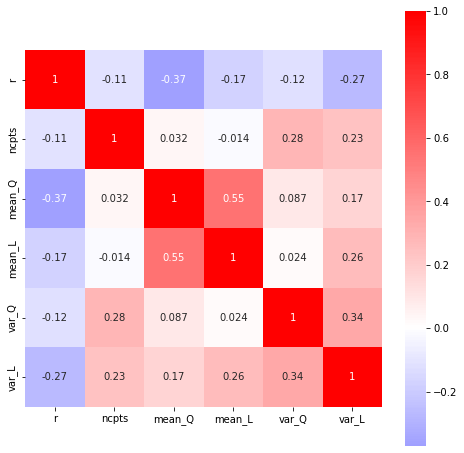

In [21]:
# corr mat for 9 fs
part_Xs = Xs[:, :-68]
corr_mat = np.corrcoef(part_Xs.T)
plt.figure(figsize=[8, 8])
sns.heatmap(corr_mat, cmap="bwr", 
            xticklabels=fsName[:-1],
            yticklabels=fsName[:-1],
            square=True,
            annot=np.round(corr_mat, 3),
            center=0)

### First reg (select features)

including

- features selection

#### Fit model

In [22]:
# The opTuningC will be used throughout
gOptC = TuningCFn(stdXs, Ys, Cs, penalty=penalty)["optC"]
print(gOptC)
#gOptC = 0.4

0.4


In [23]:
# fit the first reg
clfFinal = LogisticRegression(penalty=penalty, random_state=0, C=gOptC)
clfFinal.fit(stdXs, Ys)
coefsFinal = clfFinal.coef_.reshape(-1);

#### Bootstrap for pvals

I use Bootstrap to select finally as it has better results

We can also calculate the pvalue based on bootstrap by assuming, under $H_0$, $\beta \sim N(0, \sigma^2)$. 

In [24]:
def _run_fn_boot(i):
    np.random.seed(i)
    bootIdx = np.random.choice(len(Ys), len(Ys))
    YsBoot = Ys[bootIdx]
    stdXsBoot = stdXs[bootIdx]
    cur_optC = gOptC
    clf = LogisticRegression(penalty=penalty, random_state=0, C=cur_optC)
    clf.fit(stdXsBoot, YsBoot)
    paras_boot = clf.coef_.reshape(-1)
    return paras_boot
    
n_rep = 10000
with Parallel(n_jobs=20) as parallel:
    parass_boot = parallel(delayed(_run_fn_boot)(i) 
                   for i in tqdm(range(n_rep)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 583.09it/s]


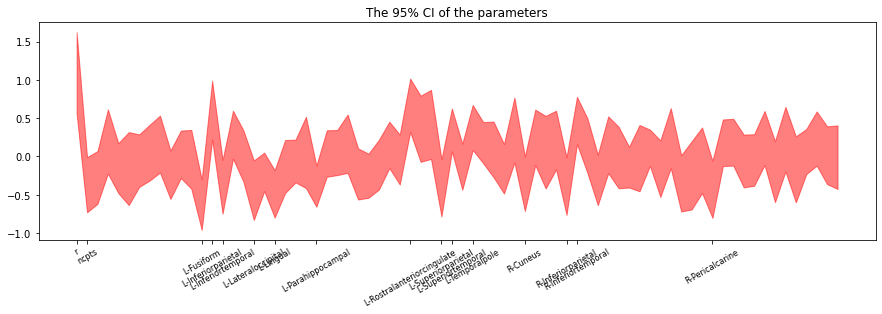

In [25]:
parass_boot = np.array(parass_boot)
lows, ups = coefsFinal-parass_boot.std(axis=0)*1.96, coefsFinal+parass_boot.std(axis=0)*1.96
kpidxBoot = np.bitwise_or(lows >0,  ups < 0)
kpidxIdBoot = np.where(kpidxBoot)[0]

xlabs = np.concatenate([fsName[:-1],
                         region_names])
plt.figure(figsize=[15, 4])
plt.fill_between(list(range(len(lows))), lows, ups, color="red", alpha=.5)
plt.title("The 95% CI of the parameters")
_ = plt.xticks(kpidxIdBoot, xlabs[kpidxIdBoot], rotation=30, fontsize=8)

select_fs_idx = kpidxBoot;

In [26]:
# Pvalue
testStatsBoot = coefsFinal/parass_boot.std(axis=0)
#testStatsBoot = parassBoot.mean(axis=0)/parassBoot.std(axis=0)
normRV = norm()
# to be consistent, I think we should use two-sided pvalue;
bootPvs = 2*(1-normRV.cdf(np.abs(testStatsBoot)));

#### The output table 

In [27]:
resDic = {
   "Feature" : xlabs[kpidxBoot],  
    "Parameters": coefsFinal[kpidxBoot],
    "Lower": lows[kpidxBoot],
    "Upper": ups[kpidxBoot],
    "Pvalues": bootPvs[kpidxBoot]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3e' % x)
resDF = pd.DataFrame(resDic)
print(resDF)

                       Feature  Parameters      Lower      Upper   Pvalues
0                            r   1.089e+00  5.581e-01  1.621e+00 5.848e-05
1                        ncpts  -3.684e-01 -7.279e-01 -8.932e-03 4.457e-02
2                   L-Fusiform  -6.296e-01 -9.582e-01 -3.009e-01 1.739e-04
3           L-Inferiorparietal   6.051e-01  2.209e-01  9.894e-01 2.026e-03
4           L-Inferiortemporal  -3.962e-01 -7.467e-01 -4.564e-02 2.675e-02
5           L-Lateraloccipital  -4.399e-01 -8.281e-01 -5.156e-02 2.640e-02
6                    L-Lingual  -4.877e-01 -7.969e-01 -1.785e-01 1.989e-03
7            L-Parahippocampal  -3.870e-01 -6.553e-01 -1.187e-01 4.696e-03
8   L-Rostralanteriorcingulate   6.682e-01  3.204e-01  1.016e+00 1.659e-04
9           L-Superiorparietal  -4.096e-01 -7.835e-01 -3.574e-02 3.176e-02
10          L-Superiortemporal   3.459e-01  6.626e-02  6.255e-01 1.533e-02
11              L-Temporalpole   3.784e-01  8.505e-02  6.718e-01 1.146e-02
12                    R-C

In [123]:
fsDic = {
   "Feature" : xlabs[:-68],  
    "Parameters": coefsFinal[:-68],
    "Lower": lows[:-68],
    "Upper": ups[:-68],
    "Pvalues": bootPvs[:-68]
}
#pd.set_option("display.precision", 3)
pd.set_option('display.float_format',lambda x : '%.3e' % x)
fsDF = pd.DataFrame(fsDic)
print(fsDF.to_latex(float_format="{:0.3f}".format))
fsDF

\begin{tabular}{llrrrr}
\toprule
{} & Feature &  Parameters &  Lower &  Upper &  Pvalues \\
\midrule
0 &       r &       1.001 &  0.415 &  1.586 &    0.001 \\
1 &   ncpts &      -0.301 & -0.667 &  0.064 &    0.106 \\
2 &     gTA &      -0.228 & -0.849 &  0.394 &    0.473 \\
3 &  SA\_inf &      -0.251 & -0.665 &  0.164 &    0.236 \\
4 &  SA\_lam &      -0.510 & -0.900 & -0.119 &    0.011 \\
5 &  mean\_Q &      -0.297 & -0.649 &  0.056 &    0.099 \\
6 &  mean\_L &       0.174 & -0.233 &  0.581 &    0.402 \\
7 &   var\_Q &      -0.110 & -0.428 &  0.208 &    0.499 \\
8 &   var\_L &      -0.152 & -0.635 &  0.330 &    0.536 \\
\bottomrule
\end{tabular}



,Feature,Parameters,Lower,Upper,Pvalues
0,r,1.001e+00,4.153e-01,1.586e+00,8.080e-04
1,ncpts,-3.014e-01,-6.668e-01,6.401e-02,1.060e-01
2,gTA,-2.276e-01,-8.492e-01,3.939e-01,4.729e-01
3,SA_inf,-2.507e-01,-6.652e-01,1.637e-01,2.357e-01
4,SA_lam,-5.096e-01,-9.002e-01,-1.190e-01,1.056e-02
5,mean_Q,-2.966e-01,-6.494e-01,5.624e-02,9.944e-02
6,mean_L,1.740e-01,-2.332e-01,5.812e-01,4.022e-01
7,var_Q,-1.097e-01,-4.277e-01,2.084e-01,4.992e-01
8,var_L,-1.522e-01,-6.345e-01,3.301e-01,5.361e-01


### Second reg

(AUC)

In [28]:
# select fs
stdXs_selected = stdXs[:, select_fs_idx]
stdXs_selected.shape

(176, 16)

In [29]:
gOptC2 = TuningCFn(stdXs_selected, Ys, Cs, penalty=penalty)["optC"]
print(gOptC2)
#gOptC2 = 3.2
def pred_run_fn_sel(trIdxs, testIdxs, curOptC=None):
    """
    This function trains a logistic regression model on the given training indices and predicts probabilities for the test indices.

    Args:
    trIdxs (array-like): Indices of the training data.
    testIdxs (array-like): Indices of the test data.

    Returns:
    eprob (array-like): Predicted probabilities for the test data.
    paras (array-like): Coefficients of the logistic regression model.
    """
    curStdXs, curYs = stdXs_selected[trIdxs, :], Ys[trIdxs]
    if curOptC is None:
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
    clf.fit(curStdXs, curYs)
    paras = clf.coef_.reshape(-1)
    eprob = clf.predict_proba(stdXs_selected[testIdxs, :])

    return eprob, paras, curOptC

3.2


In [30]:
def get_ABIC(Xs, Ys, C):
    lam = 2/C
    clf_info = LogisticRegression(penalty=penalty, random_state=0, C=C);
    clf_info.fit(Xs, Ys)
    eprobs1 = clf_info.predict_proba(Xs)[:, 1];
    logL = np.sum(Ys*np.log(eprobs1) + (1-Ys)*np.log(1-eprobs1));
    
    # effective df
    logL_der2 = -Xs.T @ np.diag(eprobs1*(1-eprobs1)) @ Xs;
    logL_der2_ridge = logL_der2 - lam * np.eye(logL_der2.shape[0]);
    dfe = np.diag(logL_der2@np.linalg.inv(logL_der2_ridge)).sum();
    aic = -2*logL + 2*dfe
    bic = -2*logL + np.log(Ys.shape[0])*dfe
    return aic, bic

get_ABIC(stdXs_selected, Ys, gOptC2)

(166.86803945225125, 195.9671972316315)

In [126]:
loo = LeaveOneOut()
with Parallel(n_jobs=30) as parallel:
    res = parallel(delayed(pred_run_fn_sel)(trIdxs, testIdxs) 
                   for trIdxs, testIdxs in tqdm(loo.split(stdXs_selected), total=len(stdXs_selected))
                  )
parass = np.array([ix[1] for ix in res])
eprobs = np.array([ix[0] for ix in res]).squeeze();
loo_auc = roc_auc_score(Ys, eprobs[:, 1])
loo_fpr, loo_tpr, loo_thresholds = roc_curve(Ys, eprobs[:, 1], pos_label=1)
loo_auc

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [01:42<00:00,  1.72it/s]


0.8256714876033059

In [127]:
def pred_run_fn_CV(i, curOptC=None):
    
    np.random.seed(i)
    nobs = stdXs_selected.shape[0]
    
    testIdxs = np.random.choice(nobs, int(nobs/5), False)
    trIdxs = np.delete(np.arange(nobs), testIdxs)
    
    curStdXs, curYs = stdXs_selected[trIdxs, :], Ys[trIdxs]
    if curOptC is None:
        curOptC = TuningCFn(curStdXs, curYs, Cs, penalty=penalty)["optC"]
    clf = LogisticRegression(penalty=penalty, random_state=0, C=curOptC)
    clf.fit(curStdXs, curYs)
    eprob = clf.predict_proba(stdXs_selected[testIdxs, :])
    cur_auc = roc_auc_score(Ys[testIdxs], eprob[:, 1])
    return cur_auc, curOptC

n_rep = 1000
with Parallel(n_jobs=20) as parallel:
    res = parallel(delayed(pred_run_fn_CV)(i, gOptC2) 
                   for i in tqdm(range(n_rep)))

aucs = [ix[0] for ix in res]
auc_m = np.mean(aucs)
auc_std = np.std(aucs)
print(f"The mean of AUC under 1000 repetitions is {auc_m:.3f} and the standard deviation is {auc_std:.3f}, "
      f"the 95% CI is ({np.quantile(aucs, 0.025):.3f}, {np.quantile(aucs, 0.975):.3f}).")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2089.26it/s]


The mean of AUC under 1000 repetitions is 0.839 and the standard deviation is 0.064, the 95% CI is (0.699, 0.949).


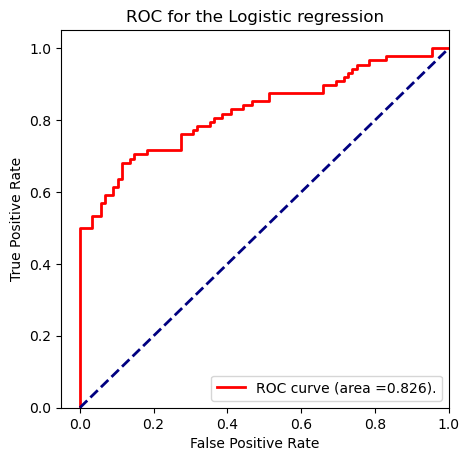

In [128]:
plt.figure(figsize=[5, 5], dpi=100)
plt.plot(loo_fpr, loo_tpr, label=f"ROC curve (area ={loo_auc:.3f}).", lw=2, color="red")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for the Logistic regression")
plt.legend(loc="lower right")